<h1 align="center">Markov Chain Monte Carlo for fun and profit</h1>
<h1 align="center"> 🎲 ⛓️ 👉 🧪 </h1>

# Doing Reproducible Science
Further Reading on this software reproducability: [The Turing Way: Guide to producing reproducable research](https://the-turing-way.netlify.app/reproducible-research/reproducible-research.html)

In the last chapter we made a nice littel graph, let's imagine we wanted to include that in a paper and we want other researchers to be able to understand and reproduce how it was generated.

There are many aspects to this but I'll list what I think is relevant here:
1. We have some code that generates the data and some code that uses it to plot the output, let's split that into two python files.
2. Our code has external dependencies on numpy and matplotlib, in the future those packages could change their behaviour in a way that breaks the code, so lets record what version our code is compatible with.
3. We also have an internal dependency on other code in this MCFF repository, that could also change so let's record the git hash of the commit where the code works for posterity.
4. The data generating process is random so we'll fix the seed as discussed in the testing section to make it reproducable.



## Making a reproducible environment

There are many ways to specify the versions of your python packages but the two most common are with a `requirements.txt` or with an `environment.yml`.

`requirements.txt` is quite simple and just lists packages and versions i.e `numpy==1.21`that can be installed with `pip install -r requirements.txt`, more details of the format [here][requirements]. The problem with requirements.txt is that it can only tell you about software installable with pip, which is often not enough.

Consequently, many people now use `environment.yml` files, which work with conda. There's a great intro to all this [here][conda-intro] which I will not reproduce here. The gist of it is that we end up with a file that looks like this:
```
#contents of environment.yml
name: recode

channels: # tells us what conda channels we need to look in
  - defaults
  - conda-forge

dependencies:
  - python=3.9
  - pytest=7.1
  - pytest-cov=3.0
  - ipykernel=6.9
  - numpy=1.21
  - scipy=1.7
  - matplotlib=3.5
  - numba=0.55
  - pre-commit
  - pip=21.2
  - pip:
      - --editable . #install MCFF from the local repository using pip and do it in editable mode

```

This file should be enough for another researcher to create an environment where they can run your code using a command like: `conda env create -f environment.yml`

Generating these files is still a little annoying, the best way I found was to manually combine the output of two commands, `conda env export --from-history` gives you just what you have manually installed into a given conda environment but not version numbers.

[requirements]: https://pip.pypa.io/en/stable/reference/requirements-file-format/#requirements-file-format
[conda-intro]: https://imperialcollegelondon.github.io/grad_school_software_engineering_course/l1-01-tools-I/index.html

In [1]:
!conda env export --from-history

name: recode
channels:
  - defaults
dependencies:
  - pytest-cov=3.0
  - watermark=2.3
  - matplotlib=3.5
  - hypothesis=6.29
  - numba=0.55
  - python=3.9
  - ipykernel=6.9
  - pre-commit=2.20
  - scipy=1.7
  - pytest=7.1
  - myst-nb=0.16
  - numpy=1.21
  - sphinx=5.0
  - pip=21.2
prefix: /Users/tom/miniconda3/envs/recode


So I also output `conda env export`, this is annoying because it also gives you dependencies. While the versions of dependencies coudl potentially be important we usually draw the line at just listing the version of directly required packages. So what I usually do is to take the above output and then use the the output of `conda env export` to set the version numbers, leaving out the number because that indicates non-breaking changes
```
#output of conda env export
name: recode
channels:
  - defaults
dependencies:
  - appnope=0.1.2=py39hecd8cb5_1001
  - asttokens=2.0.5=pyhd3eb1b0_0
  - attrs=21.4.0=pyhd3eb1b0_0
  - backcall=0.2.0=pyhd3eb1b0_0
  - blas=1.0=mkl
  - brotli=1.0.9=hb1e8313_2
  - ca-certificates=2022.4.26=hecd8cb5_0
  - certifi=2022.6.15=py39hecd8cb5_0
  - coverage=6.3.2=py39hca72f7f_0
  - many many more lines like this... sigh
```

## Spliting the code into files

To avoid you having to go away and find the files, I'll just put them here. Let's start with the file that generates the data. I'll give it what I hope is an informative name and a shebang so that we can run it with `./generate_montecarlo_walkers.py` (after doing `chmod +x generate_montecarlo_walkers.py` just once).

I'll set the seed using a large pregenerated seed, you've likely seen me use 42 in some places but that's not really best practive because it might not be entropy to reliably seed the generator.

I've also added some code that get's the commit hash of MCFF and saves it into the data file along with the date. This helps us keep track of the generated data too.

In [2]:
###### filename: generate_montecarlo_walkers.py #####
#!/usr/bin/env python3
# The above lets us run this script by just typing ./generate_montecarlo_walkers.py at the command line
"""
This script generates the data for the monte carlo walkers plot Fig. 2 in the paper {link} 
To regenerate the plot:

$ conda env create -p ./env -f environment.yml # generate the environment in a local env folder
$ conda active ./env # activate it
$ python generate_montecarlo_walkers.py # creates data.pickle
$ python plot_montecarlo_walkers.py # creates plot.pdf

Last tested and working with MCFF commit hash 63523481e89ae8c8f74a900ae43b035e3312f9c8
"""
import numpy as np
import pickle
from datetime import datetime, timezone

import MCFF
from MCFF.mcmc import mcmc_generator

import subprocess
from pathlib import Path


def get_module_git_hash(module):
    "Get the commit hash of a module installed from a git repo with pip install -e ."
    cwd = Path(module.__file__).parent
    return (
        subprocess.run(
            ["git", "rev-parse", "HEAD"], check=True, capture_output=True, cwd=cwd
        )
        .stdout.decode()
        .strip()
    )


seed = [
    2937053738,
    1783364611,
    3145507090,
]  # generated once with rng.integers(2**63, size = 3) and then saved

np.random.seed(
    seed
)  # This makes our random numbers reproducable when the notebook is rerun in order

### The measurement we will make ###
def average_color(state):
    return np.mean(state)


### Simulation Inputs ###
N = 20  # Use an NxN system
Ts = [10, 4.5, 3]  # What temperatures to use
steps = 200  # How many times to sample the state
stepsize = N**2  # How many individual monte carlo flips to do in between each sample
N_repeats = 10  # How many times to repeat each run at fixed temperature
initial_state = np.ones(shape=(N, N))  # the intial state to use
flips = (
    np.arange(steps) * stepsize
)  # Use this to plot the data in terms of individual flip attemps
inputs = dict(
    N=N,
    Ts=Ts,
    steps=steps,
    stepsize=stepsize,
    N_repeats=10,
    initial_state=initial_state,
    flips=flips,
)

### Simulation Code ###
average_color_data = np.array(
    [
        [
            [
                average_color(s)
                for s in mcmc_generator(initial_state, steps, stepsize=stepsize, T=T)
            ]
            for _ in range(N_repeats)
        ]
        for T in Ts
    ]
)

data = dict(
    MCFF_commit_hash=get_module_git_hash(MCFF),
    date=datetime.now(timezone.utc),
    inputs=inputs,
    average_color_data=average_color_data,
)

# save the data to data.pickle
with open("./walkers_plot/data.pickle", "wb") as f:
    pickle.dump(data, f)

data["inputs"]["initial_state"] = "removed for brevity"
data["inputs"]["flips"] = "removed for brevity"
data

{'MCFF_commit_hash': '03657e08835fdf23a808f59baa6c6a9ad684ee55',
 'date': datetime.datetime(2022, 7, 18, 10, 41, 12, 526345, tzinfo=datetime.timezone.utc),
 'inputs': {'N': 20,
  'Ts': [10, 4.5, 3],
  'steps': 200,
  'stepsize': 400,
  'N_repeats': 10,
  'initial_state': 'removed for brevity',
  'flips': 'removed for brevity'},
 'average_color_data': array([[[ 0.635,  0.385,  0.33 , ..., -0.035, -0.005,  0.025],
         [ 0.63 ,  0.4  ,  0.195, ..., -0.015, -0.04 ,  0.07 ],
         [ 0.54 ,  0.43 ,  0.235, ...,  0.03 ,  0.015, -0.015],
         ...,
         [ 0.6  ,  0.355,  0.115, ...,  0.165,  0.02 ,  0.02 ],
         [ 0.64 ,  0.4  ,  0.29 , ...,  0.08 ,  0.075,  0.035],
         [ 0.61 ,  0.405,  0.255, ..., -0.04 , -0.13 , -0.04 ]],
 
        [[ 0.92 ,  0.885,  0.86 , ...,  0.645,  0.58 ,  0.56 ],
         [ 0.955,  0.89 ,  0.865, ...,  0.615,  0.635,  0.63 ],
         [ 0.95 ,  0.905,  0.895, ...,  0.07 ,  0.07 ,  0.04 ],
         ...,
         [ 0.935,  0.905,  0.83 , ..., -0

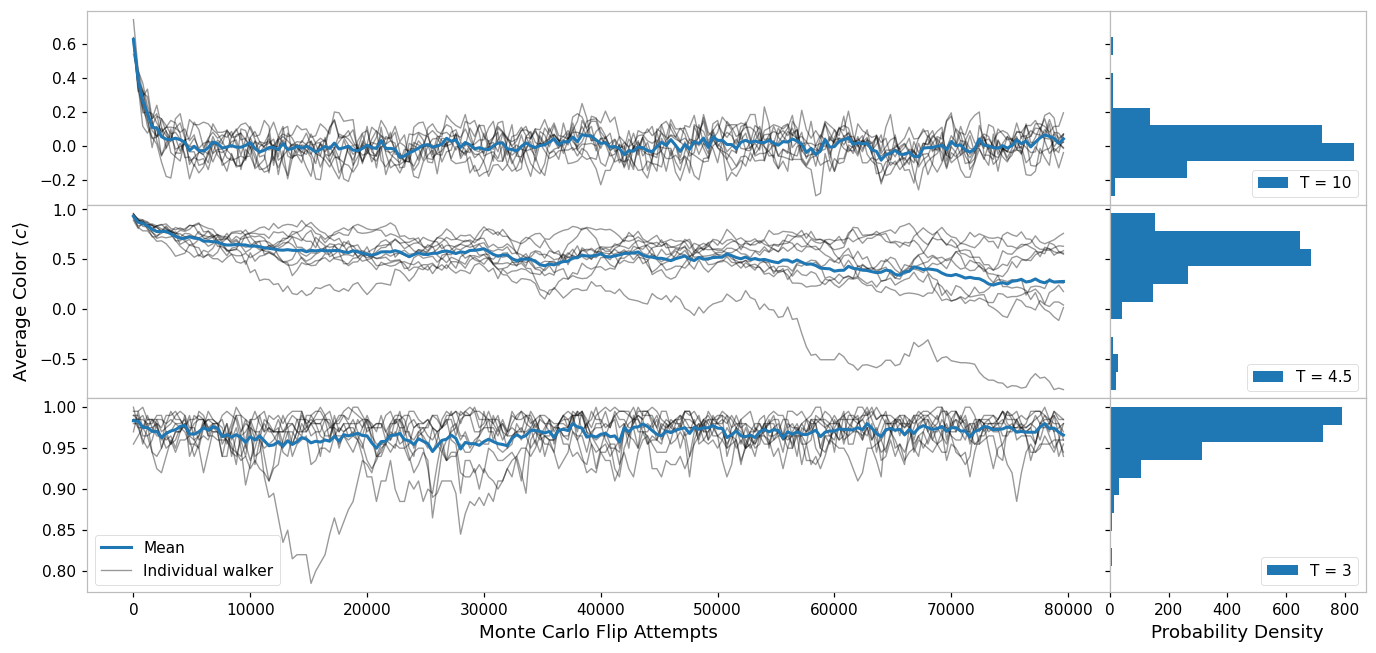

In [3]:
###### filename: plot_montecarlo_walkers.py ######
import numpy as np
import matplotlib.pyplot as plt
from numba import jit
import pickle

# This loads some custom styles for matplotlib
import json, matplotlib

with open("assets/matplotlibrc.json") as f:
    matplotlib.rcParams.update(json.load(f))

from itertools import count

with open("./walkers_plot/data.pickle", "rb") as f:
    data = pickle.load(f)

# splat the keys and values back into the global namespace,
# beware that this could overwrite previously defined variables like 'count' by accident
globals().update(**data)
globals().update(**data["inputs"])


fig, axes = plt.subplots(
    figsize=(15, 7),
    nrows=3,
    ncols=2,
    sharey="row",
    sharex="col",
    gridspec_kw=dict(hspace=0, wspace=0, width_ratios=(4, 1)),
)

for i, ax, hist_ax in zip(count(), axes[:, 0], axes[:, 1]):
    c = average_color_data[i]
    indiv_line, *_ = ax.plot(flips, c.T, alpha=0.4, color="k", linewidth=0.9)
    (mean_line,) = ax.plot(flips, np.mean(c, axis=0))
    hist_ax.hist(c.flatten(), orientation="horizontal", label=f"T = {Ts[i]}")

axes[-1, 0].set(xlabel=f"Monte Carlo Flip Attempts")
axes[-1, 1].set(xlabel="Probability Density")
axes[1, 0].set(ylabel=r"Average Color $\langle c \rangle$")
axes[-1, 0].legend([mean_line, indiv_line], ["Mean", "Individual walker"])
for ax in axes[:, 1]:
    ax.legend(loc=4)

fig.savefig("./walkers_plot/plot.pdf")

## Citations and DOIs

Now that we have a nicely reproducable plot, let's share it with the world. The easiest way is probably to put your code in a hosted git repository like Github or Gitlab. 

Next, let's mint a shiny Digital Object Identifier (DOI) for the repository, using something like [Zenodo](https://zenodo.org/). These services archive a snapshot of the repository and assign a DOI to that snapshot, this is realy useful for citing a particular version of the software. 

Finally let's add a `citation.cff` file to the root of the repository, this makes it easier for people who might cite this software to generate a good citation for it. We can add the zenodo DOI to it too. You can read more about `citation.cff` files [here](https://citation-file-format.github.io/) and there is a convenient generator tool [here](https://citation-file-format.github.io/cff-initializer-javascript/).

In [4]:
%load_ext watermark
%watermark -n -u -v -iv -w -g -r -b -a "Thomas Hodson" -gu "T_Hodson"

Author: Thomas Hodson

Github username: T_Hodson

Last updated: Mon Jul 18 2022

Python implementation: CPython
Python version       : 3.9.12
IPython version      : 8.4.0

Git hash: 03657e08835fdf23a808f59baa6c6a9ad684ee55

Git repo: https://github.com/ImperialCollegeLondon/ReCoDE_MCMCFF.git

Git branch: main

matplotlib: 3.5.1
json      : 2.0.9
numpy     : 1.21.5
MCFF      : 0.0.1

Watermark: 2.3.1

